In [1]:
import jax
jax.config.update("jax_enable_x64", True)
# jax.config.update("jax_debug_nans", True)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import jax.numpy as jnp
import jax.random as jrng
import numpy as np
import ultraplot as uplt

In [4]:
from affine_invar_hmc import ensemble_hmc
from raytrace_jax import sample_raytrace

In [5]:
from numpyro.diagnostics import print_summary

def _emcee_to_numpyro(chain, rng_key):
    inds = jrng.permutation(rng_key, chain.shape[0])
    _, rng_key = jrng.split(rng_key)    
    
    samples = dict()
    for i in range(chain.shape[2]):
        samples[f"p{i}"] = chain[inds, :, i].T
    return samples, rng_key

def _neg_log_like_gauss1d(x, sigma):
    return 0.5 * jnp.sum(x**2) / sigma**2 + jnp.log(sigma)

def _neg_log_like(x):
    # y = x[0]
    # x = x[1:]
    # return _neg_log_like_gauss1d(y, 3) + _neg_log_like_gauss1d(x, jnp.exp(y / 2))
    # return _neg_log_like_gauss1d(y, 3) + _neg_log_like_gauss1d(x, 200)

    # return jnp.sum(((1 - y)**2 + 100.0 * (x - y**2)**2) / 20)

    # return (jnp.sum(x**2) - 1)**2 / 0.25**2
    return _neg_log_like_gauss1d(x, 1)

def _log_like(x):
    return -1.0 * _neg_log_like(x)

In [6]:
n_dims = 2
n_walkers = max(2 * n_dims, 20) # max(2 * n_dims, 200)
n_samples = 1000000

rng_key = jrng.PRNGKey(seed=10)
rng_key, init_key = jrng.split(rng_key)
x_init_rt = jrng.normal(init_key, shape=(n_dims)) * 0.01
x_init_af = jrng.normal(init_key, shape=(n_walkers, n_dims)) * 0.01

if False:
    h = 0.05
    n_steps = 10
    # n_samples *= 10
    chain, _ = sample_raytrace(
        key=rng_key, 
        params_init=x_init_rt, 
        log_prob_fn=_log_like, 
        n_steps=n_samples, 
        n_leapfrog_steps=n_steps, 
        step_size=h, 
        refresh_rate=0,
        sample_hmc=False, 
        metro_check=1)
    chain = chain.reshape((-1, 1, n_dims))
else:
    n_steps = 2
    h = 1 / n_steps
    chain, acc, nloglike = ensemble_hmc(
        _neg_log_like,
        x_init_af, 
        n_samples,
        n_dims, 
        n_walkers, 
        h, 
        n_steps, 
        rng_key
    )

samples, rng_key = _emcee_to_numpyro(chain[n_samples // 2:, :, :], rng_key)

print_summary(samples)
print(np.mean(chain), np.std(chain))

sampling: 100%|████████████████████| 1000000/1000000 [00:25<00:00, 38869.01it/s]


acceptance rate: 97.31%

                mean       std    median      5.0%     95.0%     n_eff     r_hat
        p0     -0.00      1.00     -0.00     -1.65      1.64 9999421.03      1.00
        p1     -0.00      1.00     -0.00     -1.66      1.64 10000543.34      1.00

-0.0004520121705807957 1.0001885821715615


(Array(0.00332357, dtype=float64), Array(1.00256185, dtype=float64))

KeyError: 'p1'

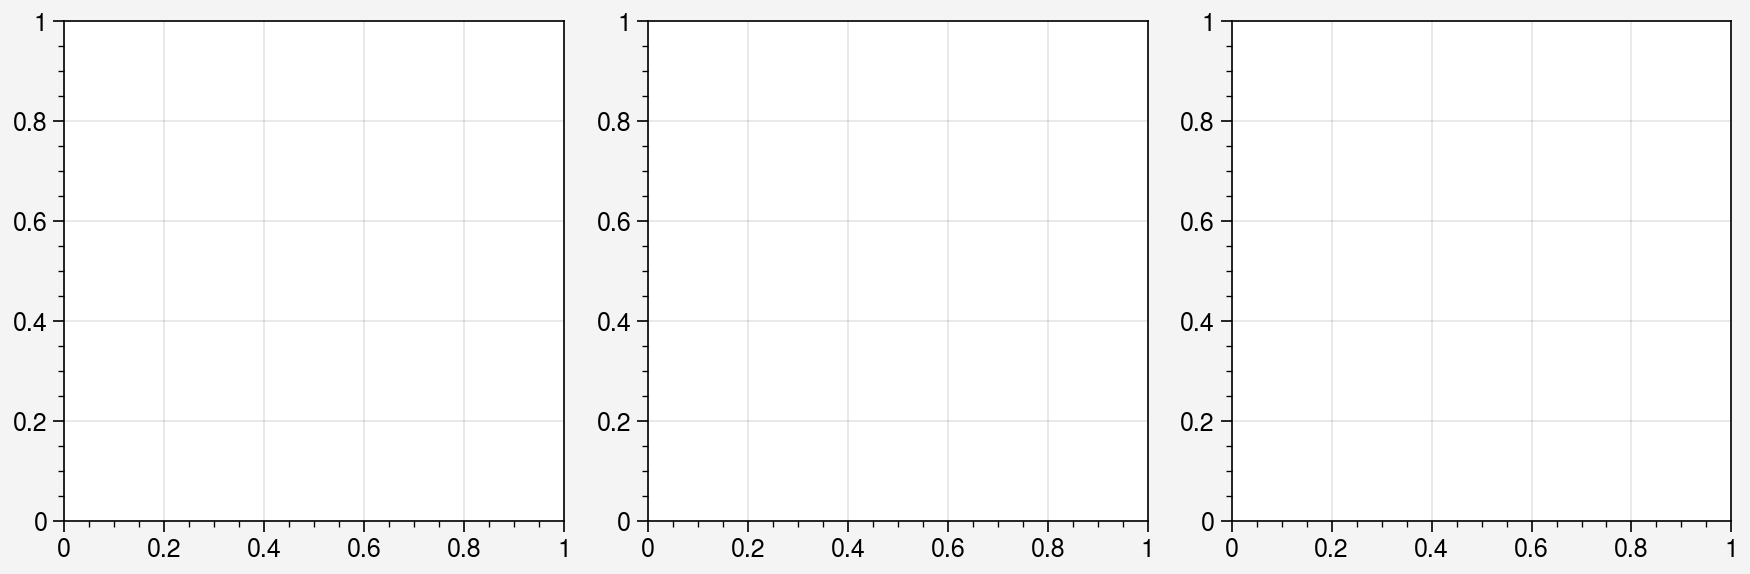

In [ ]:
fig, axs = uplt.subplots(ncols=3, nrows=1, share=0)

axs[0, 0].hexbin(
    samples["p1"].ravel(), 
    samples["p0"].ravel(), 
    norm="log",
    # extent=(-20, 20, -10, 10),
    discrete=False,
    gridsize=100,
);

# axs.plot(
#     samples["p1"][0, :1000000], 
#     samples["p0"][0, :1000000], 
#     "k,",
# )
# axs[0, 0].format(xlim=(-20, 20), ylim=(-10, 10))

axs[0, 1].hist(
    samples["p0"].ravel(), 
    bins=50,
);

axs[0, 2].hist(
    samples["p1"].ravel(), 
    bins=50,
);
